source: https://langchain-ai.github.io/langchain-benchmarks/notebooks/retrieval/semi_structured_benchmarking/ss_eval_long_context.html

# Semi-structured eval: Long-context
Semi-structured Reports is a public dataset that contains question-answer pairs from documents with text and tables.

The question-answer pairs are derived from the tables as well as some of the paragraphs in the docs.

We evaluation performance of long context LLMs on this dataset.

In [3]:
import getpass
import os

os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
env_vars = ["LANGCHAIN_API_KEY", "OPENAI_API_KEY", "ANTHROPIC_API_KEY"]
for var in env_vars:
    if var not in os.environ:
        os.environ[var] = getpass.getpass(prompt=f"Enter your {var}: ")

Enter your LANGCHAIN_API_KEY: ········
Enter your ANTHROPIC_API_KEY: ········


### Dataset
Fetch the associated PDFs from remote cache for the dataset so that we can perform ingestion.

In [4]:
import os

from langchain_benchmarks import clone_public_dataset, registry
from langchain_benchmarks.rag.tasks.semi_structured_reports import get_file_names

# Task
task = registry["Semi-structured Reports"]

# Files used
paths = list(get_file_names())
files = [str(p) for p in paths]

Clone the dataset so that it’s available in our LangSmith datasets.



In [5]:
clone_public_dataset(task.dataset_id, dataset_name=task.name)

Dataset Semi-structured Reports already exists. Skipping.
You can access the dataset at https://smith.langchain.com/o/8088c1e2-0bd7-567f-a9a3-e89380e5cb42/datasets/0aba67b4-6e39-4f9d-b586-57a963cb724d.


### Load
Concatenate the documents.

In [6]:
from langchain.document_loaders import PyPDFLoader

texts = []
for fi in files:
    loader = PyPDFLoader(fi)
    pdf_pages = loader.load()
    texts.extend(pdf_pages)

texts = [t.page_content for t in texts]
text_string = " /// New Document /// ".join(texts)

### Run
Create a chain for each long-context LLM where we pass in the concatenated documents.

In [7]:
from langchain.chat_models import ChatOpenAI
from langchain.chat_models import ChatAnthropic
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.runnable import RunnablePassthrough


def create_chain(model):
    # Prompt template
    template = """Answer the question based only on the following context, which can include text and tables:
    {context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    chain = (
        {
            "context": lambda x: text_string,
            "question": RunnablePassthrough(),
        }
        | prompt
        | model
        | StrOutputParser()
    )

    return chain


# OAI 128k
model = ChatOpenAI(temperature=0, model="gpt-4-1106-preview")
chain_oai_128k = create_chain(model)

# Anthropic 100k, v2
#model = ChatAnthropic(temperature=0, model="claude-2")
#chain_claude = create_chain(model)

# Anthropic 100k, v2.1
#model = ChatAnthropic(temperature=0, model="claude-2.1")
#chain_2_1_claude = create_chain(model)

### Eval
Run eval onm our dataset, Semi-structured Reports.

In [8]:
import uuid
from langsmith.client import Client
from langchain.smith import RunEvalConfig

# Config
client = Client()
eval_config = RunEvalConfig(
    evaluators=["cot_qa"],
)

# Experiments
chain_map = {
    "oai_128k": chain_oai_128k,
#    "claude2_100k_v2": chain_claude,
#    "claude2_100k_v2.1": chain_2_1_claude,
}

# Run evaluation
run_id = uuid.uuid4().hex[:4]
test_runs = {}
for project_name, chain in chain_map.items():
    test_runs[project_name] = client.run_on_dataset(
        dataset_name=task.name,
        llm_or_chain_factory=lambda: (lambda x: x["Question"]) | chain,
        evaluation=eval_config,
        verbose=True,
        project_name=f"{run_id}-{project_name}",
        project_metadata={"chain": project_name},
    )

View the evaluation results for project '4f83-oai_128k' at:
https://smith.langchain.com/o/8088c1e2-0bd7-567f-a9a3-e89380e5cb42/datasets/0aba67b4-6e39-4f9d-b586-57a963cb724d/compare?selectedSessions=6085d39c-d1b1-44fc-b628-f70d4d7b9787

View all tests for Dataset Semi-structured Reports at:
https://smith.langchain.com/o/8088c1e2-0bd7-567f-a9a3-e89380e5cb42/datasets/0aba67b4-6e39-4f9d-b586-57a963cb724d
[>                                                 ] 0/28

Chain failed for example 813ea2d1-4316-4bfb-b1b2-43b96d545cdf with inputs {'Question': "What was Datadog's net income for the three months that ended September 30 in 2023 and 2022?"}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36127. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[->                                                ] 1/28

Chain failed for example 80216a8b-cae9-43e3-9be6-57a6bfbaaa25 with inputs {'Question': 'How much did Datadog spend on research and development for the three months ended September 30,2023?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36129. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}
Chain failed for example dbde8588-8b03-41e2-aa09-31ab0320ea88 with inputs {'Question': 'What was Datadog’s current and non-current deferred revenue as of September 30, 2023?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36126. Visit https://platform.openai.com/a

[---->                                             ] 3/28

Chain failed for example 45c1960f-674f-4fa8-8f2e-f04170dff3c8 with inputs {'Question': 'How much capitalized software development costs did Datadog report for the three months that ended September 30, 2023?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36134. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[------>                                           ] 4/28

Chain failed for example 351d2a74-07f2-43b9-8077-a78106e21ae0 with inputs {'Question': 'Can you calculate the year-over-year percentage change in Datadog’s research and development spending for the three months ended September 30,2023?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36141. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[-------->                                         ] 5/28

Chain failed for example bfc0311a-6d35-4b1c-bae0-d0e46707f849 with inputs {'Question': 'How many bank failures occurred between 2021 and 2023?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36118. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[---------->                                       ] 6/28

Chain failed for example f274198c-baa5-4eaa-b8d8-427f486024f8 with inputs {'Question': 'What is the total amount of underreported federal tax income from 2011-2013?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36123. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}
Chain failed for example 7e5c821c-4a5c-4382-a5c6-8ba381ea49a0 with inputs {'Question': 'What were the deposits from bank failures for 2001-2020 and 2021-2023?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36122. Visit https://platform.openai.com/account/rate-limits to learn more.', 'ty

[------------->                                    ] 8/28

Chain failed for example 3b721362-fc29-4d14-9fa3-5aaffddf2e6d with inputs {'Question': 'Can you calculate the year-over-year percentage change in net sales for the AWS segment from 2022 to 2023 for the three months ended September 30?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36141. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}
Chain failed for example 5f0e62da-7f5f-4151-bb5f-491de60be2de with inputs {'Question': 'What factors contributed to the federal income tax gap in 2011-2013, both in percentage and dollar terms?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min:

[----------------->                                ] 10/28

Chain failed for example 46f2dd15-c2ab-4d0a-bf5d-4c172d3a3ae0 with inputs {'Question': 'Can you calculate the year-over-year percentage change in AWS operating income for the three months that ended September 30, 2023?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36137. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}
Chain failed for example c541c59a-cc42-4a06-8085-d44102ce2398 with inputs {'Question': 'For the three months that ended September 30, 2023, what percentage of total net sales did AWS contribute?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, R

[-------------------->                             ] 12/28

Chain failed for example 26f099ce-6672-4fa2-aaa4-3cd65f4a3627 with inputs {'Question': 'Can you calculate the year-over-year percentage change in Amazon net product sales from 2022 to 2023 for the nine months ended September 30?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36139. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[---------------------->                           ] 13/28

Chain failed for example f412803c-ca62-47e4-bb72-7b657d13addc with inputs {'Question': "What was the year-over-year percentage change in revenue growth for Microsoft's Intelligent Cloud segment from 2022 to 2023 for the three months that ended September 30?"}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36146. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[------------------------>                         ] 14/28

Chain failed for example bdc56941-33cd-4ae3-94cd-5b0e59af4561 with inputs {'Question': "For the three months ended September 30, 2023, what percentage of total revenue does Intelligent Cloud represent when considering Microsoft's three main business units (Productivity and Business Processes, Intelligent Cloud, and More Personal Computing)?"}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36168. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[-------------------------->                       ] 15/28

Chain failed for example e0fb68ab-1374-49fd-87bd-5e700b2b3439 with inputs {'Question': 'For the three months ended September 30, 2023, what percentage of total Alphabet revenues does Google Cloud comprise?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36133. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}
Chain failed for example d0916586-8647-4d98-bc7d-3f599ed785ea with inputs {'Question': 'Can you calculate the year-over-year percentage change in revenue for Google Cloud from 2022 to 2023 for the Quarter Ended September 30?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per mi

[----------------------------->                    ] 17/28

Chain failed for example 3518405e-b07b-4c2f-a473-fa0045c16f26 with inputs {'Question': 'For the three months ended September 30, 2022, how much revenue did Google advertising and Google Cloud account for?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36133. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[------------------------------->                  ] 18/28

Chain failed for example 1c579a74-21b6-49f1-9a17-2dc9c5c4de80 with inputs {'Question': 'What were the revenues for AWS, Google Cloud, and Microsoft Intelligent Cloud for the three months that ended September 30, 2023?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36136. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[--------------------------------->                ] 19/28

Chain failed for example 69d28718-2fd1-4bb8-845d-2de2af664e27 with inputs {'Question': 'What percentage of total revenues do AWS, Google Cloud, and Microsoft Intelligent Cloud contribute for the three months ended September 30, 2023?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36140. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[----------------------------------->              ] 20/28

Chain failed for example 70045d2c-bfd8-4292-ab5f-3c5c396e3632 with inputs {'Question': 'What is the Microsoft Research and development expense for the Three Months Ended September 30, 2023?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36129. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}
Chain failed for example 652d39b8-06c6-47a1-8368-9768a12805b3 with inputs {'Question': "What is Amazon's Diluted earnings per share for the Nine Months that Ended September 30, 2023?"}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36128. Visit https://platform.op

[---------------------------------------->         ] 23/28

Chain failed for example 83d89a67-3f81-4a4b-be67-ba5e56c070be with inputs {'Question': "What is Datadog's Non-GAAP gross margin for the Nine Months Ended September 30, 2023?"}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36125. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[------------------------------------------>       ] 24/28

Chain failed for example 771e5284-f845-4e48-9cd8-c46bff13964c with inputs {'Question': 'How many viewers did Amazon Prime attract to the Thursday Night Football season opener?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36126. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[-------------------------------------------->     ] 25/28

Chain failed for example bed70228-f017-4f73-98de-3327e32eb651 with inputs {'Question': 'What are the two main resolution methods that the FDIC normally uses for failing banks?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36126. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}
Chain failed for example 0f1ea0a0-eab1-4c50-90c6-b25ee35e9767 with inputs {'Question': 'How long has the IRS has been estimating the size and composition of the tax gap?'}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on requests per min (RPM): Limit 40, Used 40, Requested 1. Please try again in 1.5s. Visit https://platform.open

[----------------------------------------------->  ] 27/28

Chain failed for example 4e8d1c00-ebf7-4ce4-b17a-88eb152ca20e with inputs {'Question': "Based on Datadog's report 10 Insights on Real-World Container Use, what percentage of container organizations now run serverless containers and how does this compare to two years ago?"}
Error Type: RateLimitError, Message: Error code: 429 - {'error': {'message': 'Request too large for gpt-4-1106-preview in organization org-BoDRB68X6JLOaFbjaoUIsGvY on tokens_usage_based per min: Limit 10000, Requested 36150. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens_usage_based', 'param': None, 'code': 'rate_limit_exceeded'}}


[------------------------------------------------->] 28/28

### Failure Analysis
Look at failures for GPT-4 128k wrt the answer location in the context.

Prior work has done this for long context LLMs.

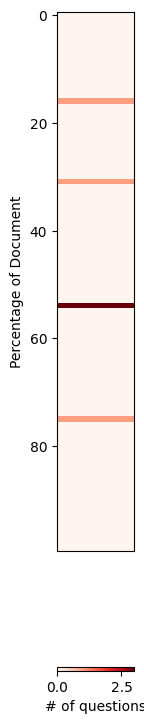

In [11]:
import numpy as np
import matplotlib.pyplot as plt


def find_all_phrase_locations(phrases, text):
    """
    # Function to find all locations of each phrase in the text string
    """
    locations = []
    for phrase in phrases:
        start = 0
        while start < len(text):
            start = text.find(phrase, start)
            if start == -1:  # No more occurrences
                break
            # Convert location to percentage of the document
            location_percent = (start / len(text)) * 100
            locations.append(location_percent)
            start += len(phrase)  # Move past this occurrence
    return locations


# Unique statments related to each failed question
short_phrase_list = [
    "Booking.com, GoDaddy",  # AWS question
    "MICROSOFT CORPORATIONINCOME STATEMENTS",  # MSFT
    "Operating income $ 5,403",  # AWS question
    "Net sales $ 20,538 $ 23,059",  # AWS question
    "Research and development (1)(3) 240,225  205,388",  # DDOG
    "Net sales $ 78,843 $ 87,887",  # AWS question
]

# Finding all the locations of each phrase in the text_string
phrase_locations = find_all_phrase_locations(short_phrase_list, text_string)

# Create a 2D matrix for heatmap
heatmap_matrix = np.zeros((1, 100))
for location in phrase_locations:
    segment = int(location)
    heatmap_matrix[0, segment] += 1  # Increment the count for the segment

# Invert the matrix so that x and y are flipped
inverted_heatmap_matrix = np.transpose(heatmap_matrix)

# Plotting the inverted heatmap
fig, ax = plt.subplots(figsize=(1, 10))  # Adjust figure size to make x-axis narrower
cax = ax.imshow(
    inverted_heatmap_matrix,
    cmap="Reds",
    aspect="auto",
    vmin=0,
    vmax=inverted_heatmap_matrix.max(),
)
fig.colorbar(cax, label="# of questions", orientation="horizontal")
ax.set_ylabel("Percentage of Document")
ax.set_xticks([])
plt.show()